In [37]:
import netCDF4     
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
plt.rcParams['figure.figsize'] = 15,8
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import from_levels_and_colors
from matplotlib import colors
import matplotlib
import os
import sys
import pandas as pd
import pyproj

In [38]:
# set the path to the case_path
case_path='/data/dusan/emPY/case_run'
sys.path.append(case_path)
import emPY_config_file

# create lon, lat to the basemap
grid=emPY_config_file.grid_params
xorig, yorig = grid['XORIG'], grid['YORIG']
xcell, ycell =grid['XCELL'], grid['XCELL']
nrows, ncols = grid['ni'], grid['nj']

x = [xorig + i * xcell for i in range(ncols)]
y = [yorig + j * ycell for j in range(nrows)]
x,y  = np.meshgrid(x, y)
p = pyproj.Proj(emPY_config_file.projection)
#lon, lat of the domain, for grid corners / used for pictures
lon, lat = p(x, y, inverse=True)
#lon, lat of the domain, for grid centers / used for calculations
lon_center, lat_center=p(x+xcell/2, y+xcell/2, inverse=True)

In [39]:
# adjust base map automatic
#mapb=Basemap(projection='lcc',lat_1=emPY_config_file.projection['lat_1'],lat_2=emPY_config_file.projection['lat_2'],lat_0=lat.mean(),lon_0=lon.mean(),width=(x.max()-x.min()),height=(y.max()-y.min()),resolution='h')
#manual set base map
mapb=Basemap(projection='lcc',lat_1=46.24470138549805,lat_2=46.24470138549805,lat_0=48.7,lon_0=19.7,width=425780,height=216351,resolution='h')

# Analyse all pollutants

In [40]:
out_dir=emPY_config_file.to_domain_output_directory
# set the area inventories which you want analyse
list_inv_A=['TNO_SK_2015_A']
# set the point inventories which you want analyse
list_inv_P=['TNO_SK_2015_P']

In [41]:
pollutant_list=[]
for _ in list_inv_A:
    pollutant_list+=list(map(lambda x: x.split('-')[1], os.listdir(out_dir+'/'+_)) )
pollutant_points=[]
for _ in list_inv_P:
    pollutant_points+=list(set(pd.read_csv(out_dir+'/point_sources/'+ _).columns) - set(['cat_internal', 'ISTACK', 'LATITUDE', 'LONGITUDE', 'STKDM', 'STKHT',
       'STKTK', 'STKVE', 'STKFLW', 'STKCNT', 'ROW', 'COL', 'XLOCA', 'YLOCA',
       'IFIP', 'LMAJOR', 'LPING']))
print(f"In area sources there are pollutants : {list(set(pollutant_list))} ")
print(f"In point sources there are pollutants: {list(set(pollutant_points))} ")
all_polutants=list(set(pollutant_points).union(pollutant_list))
all_polutants.sort()
print(f"All pollutants are : {all_polutants} ")

In area sources there are pollutants : ['PEC', 'POC', 'PSO4', 'CH4', 'PMC', 'PNA', 'SO2', 'BZN', 'NH3', 'NO2', 'PMOTHR', 'NMBVOC', 'CO', 'NO'] 
In point sources there are pollutants: ['PEC', 'POC', 'PSO4', 'PMC', 'PNA', 'SO2', 'NH3', 'BZN', 'NO', 'NMBVOC', 'PMOTHR', 'CO', 'NO2', 'CH4'] 
All pollutants are : ['BZN', 'CH4', 'CO', 'NH3', 'NMBVOC', 'NO', 'NO2', 'PEC', 'PMC', 'PMOTHR', 'PNA', 'POC', 'PSO4', 'SO2'] 


In [42]:
dic_pol={}
for poll in all_polutants:
    dic_pol[poll]=np.zeros(lon.shape)
    for _ in list_inv_A:
        for file in os.listdir(out_dir+'/'+_):
            f_split=file.split( "-" )


            if f_split[1]==poll:
               dic_pol[poll]+=np.load('{0}/{1}'.format(out_dir+'/'+_,file))

In [58]:
(lambda x: print(x**2))(5)

25


In [59]:
def squarex(x):
    return x**2

In [60]:
squarex(5)

25

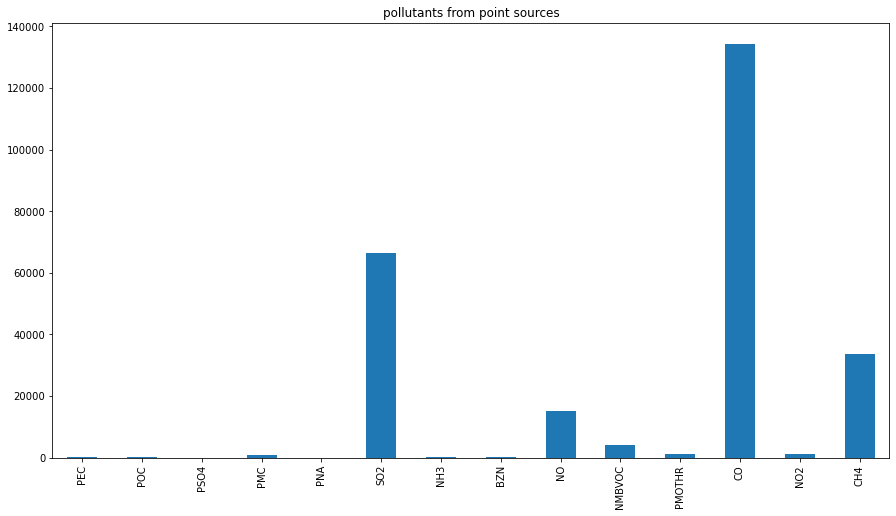

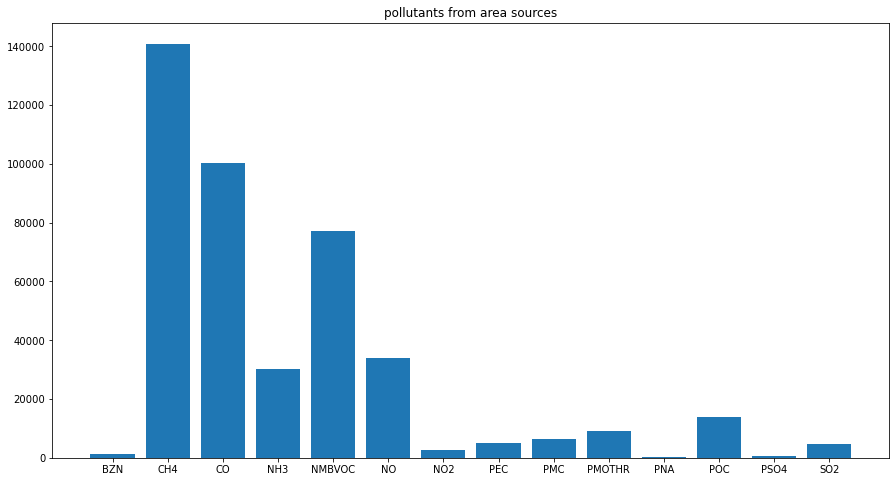

In [55]:
pd.read_csv(out_dir+'/point_sources/'+ 'TNO_SK_2015_P')[list(set(pollutant_points))].sum().plot.bar()
plt.title('pollutants from point sources')
plt.show()

plt.bar(list(dic_pol.keys()), list(map(lambda x: x.sum(),dic_pol.values())))
plt.title('pollutants from area sources')
plt.show()

## Map of area emissions

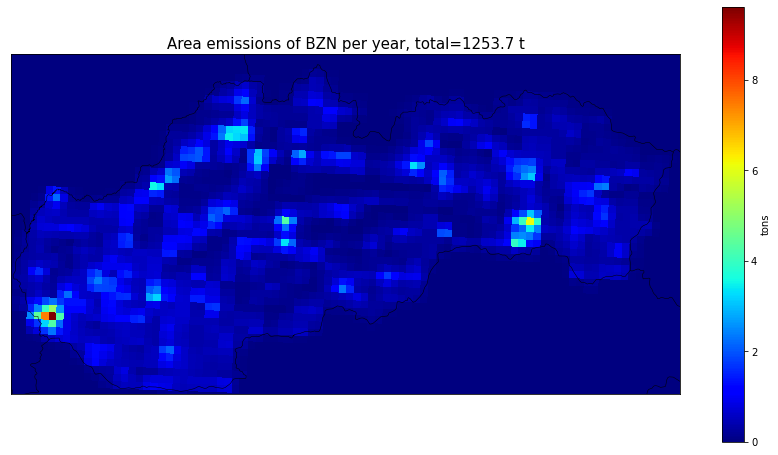

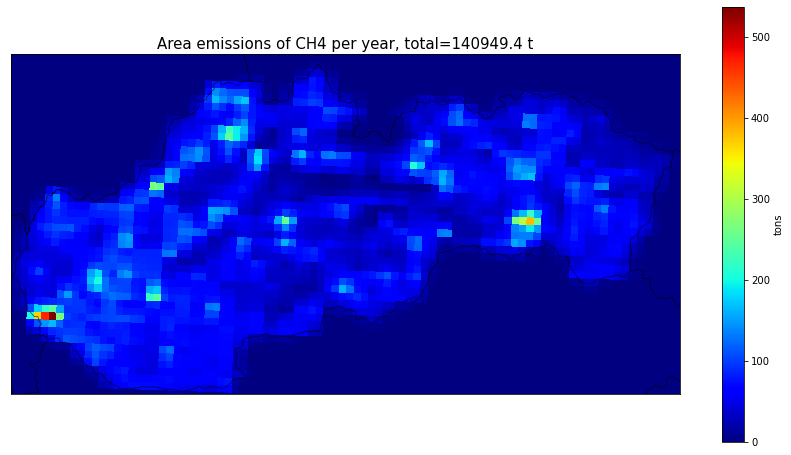

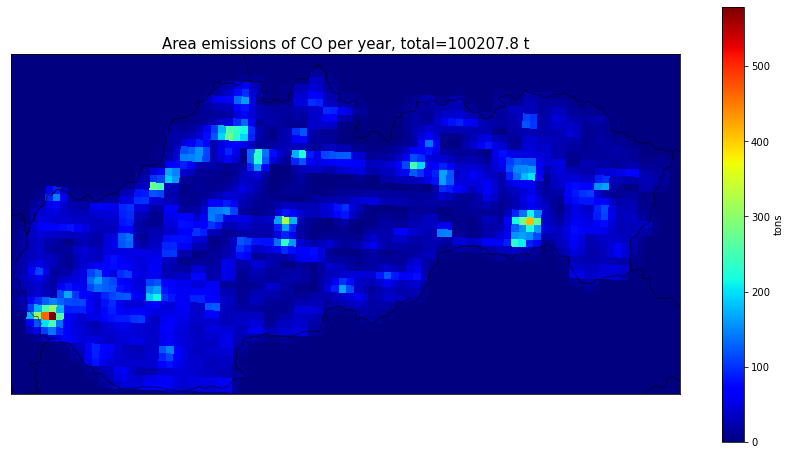

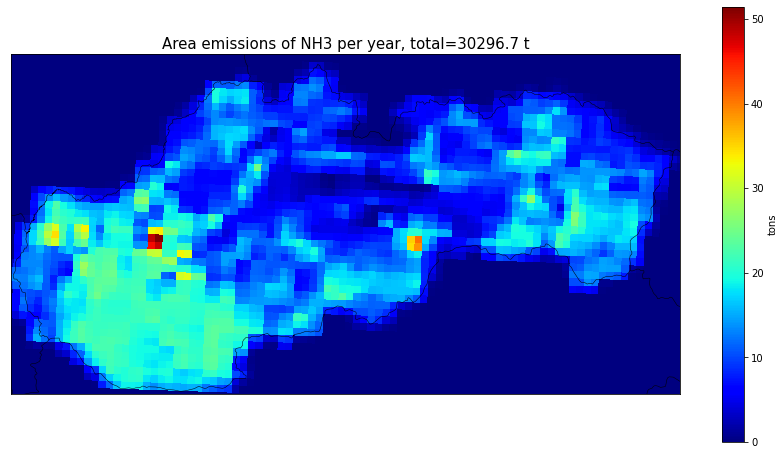

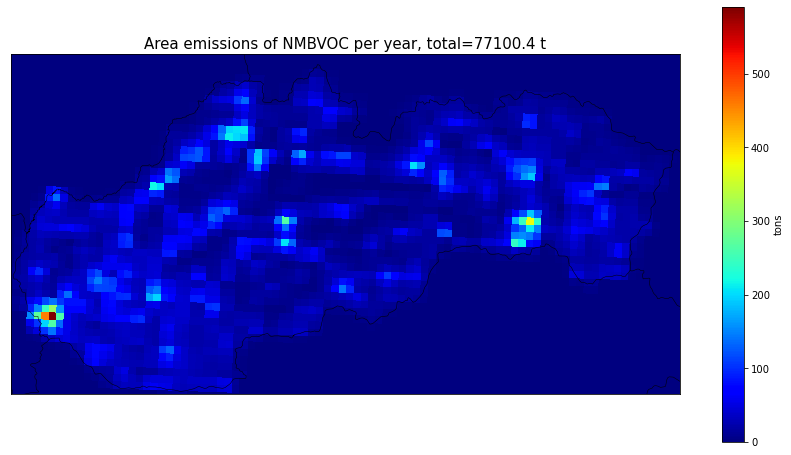

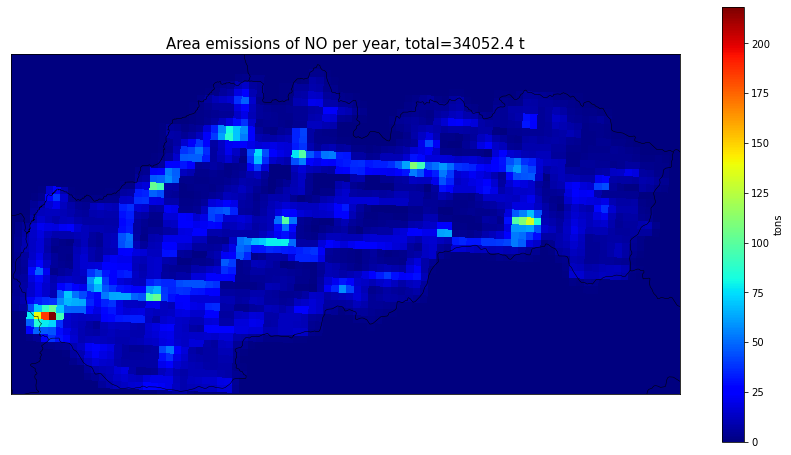

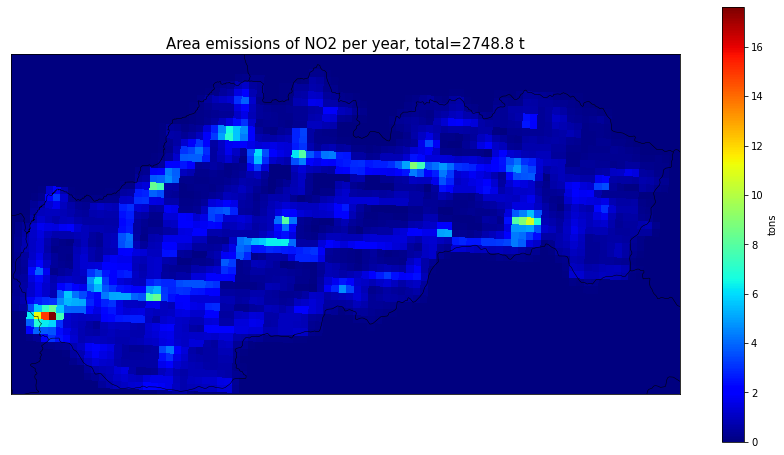

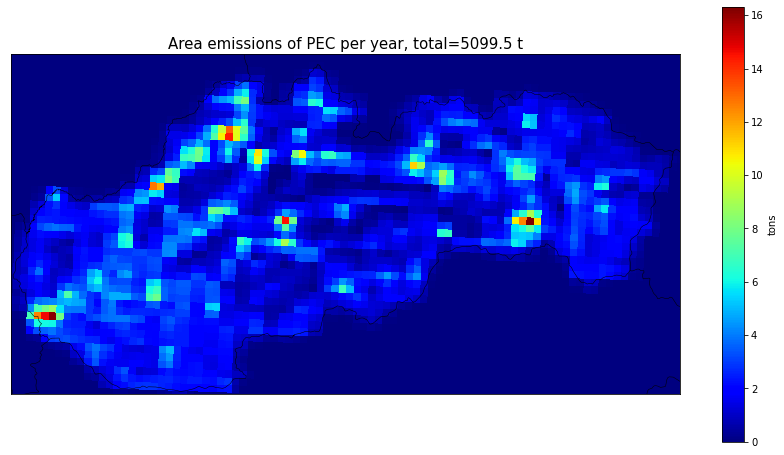

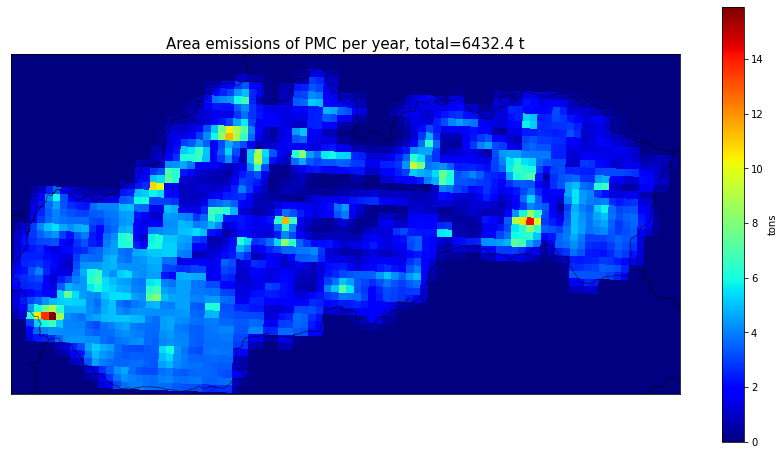

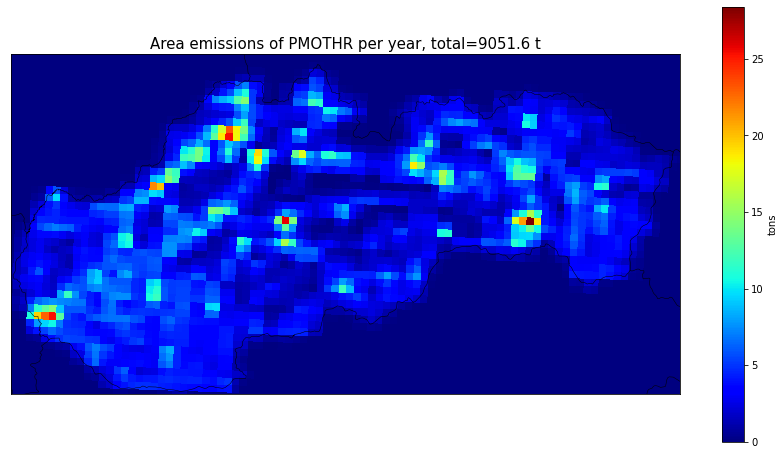

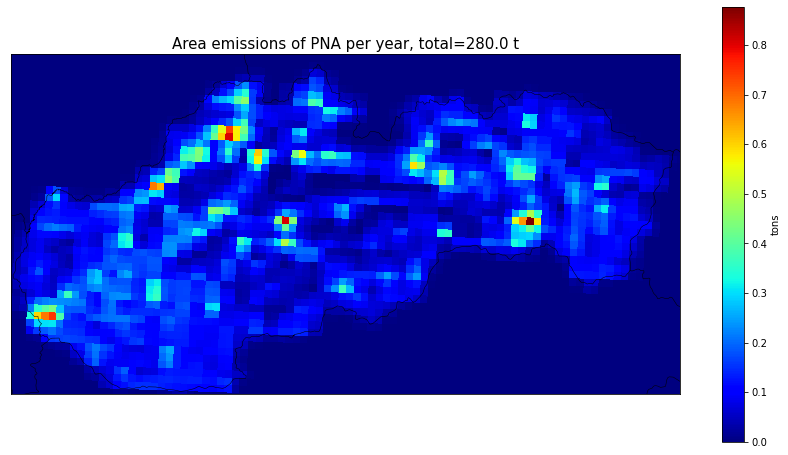

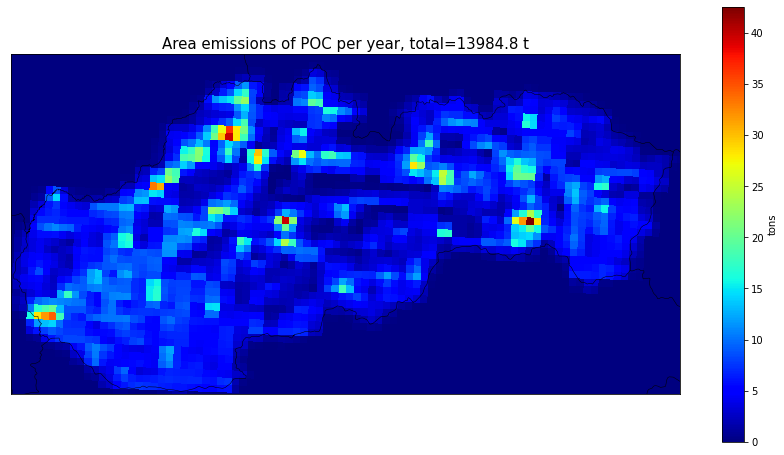

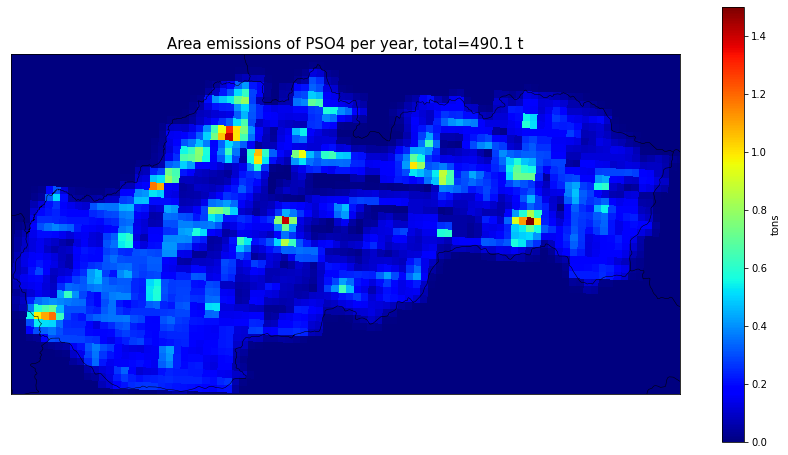

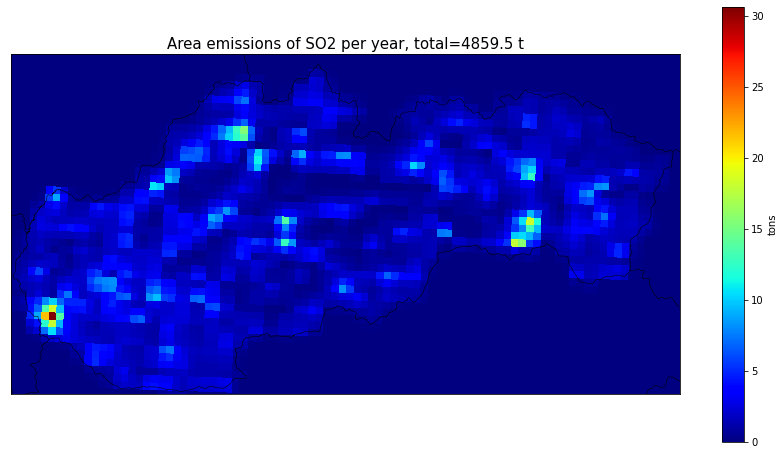

In [44]:
for pol in dic_pol:

    mapb.drawcountries()
    mapb.pcolormesh(lon,lat,dic_pol[pol],cmap=plt.cm.jet,latlon=True) 
    plt.colorbar(label='tons')
    plt.title(f'Area emissions of {pol} per year, total={np.sum(dic_pol[pol]):.1f} t', size=15)
    plt.show()

## Map of point sources

In [53]:
def getclosest_ij(lats,lons,latpt,lonpt):
    # find squared distance of every point on grid
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2
    # 1D index of minimum dist_sq element
    minindex_flattened = dist_sq.argmin()
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flattened, lats.shape)

dic_pol_p={}
for poll in pollutant_points:
    dic_pol_p[poll]=np.zeros(lon.shape)
for _ in list_inv_P:
    points=pd.read_csv(out_dir+'/point_sources/'+_)
    points['coord']=points.apply(lambda x: getclosest_ij(lat_center, lon_center, x['LATITUDE'],x['LONGITUDE']),axis=1 )
    for index, row in points.iterrows():
        for poll in pollutant_points:
            dic_pol_p[poll][row['coord']]+=row[poll]    
      

In [56]:
points

,cat_internal,ISTACK,LATITUDE,LONGITUDE,STKDM,STKHT,STKTK,STKVE,STKFLW,STKCNT,...,PMC,PEC,POC,PNA,PSO4,PMOTHR,NMBVOC,CH4,NH3,coord
0,1010,787569,48.15625,17.0625,4.1,125.9,401.2,10.4,137.306449,1,...,3.540844e-02,1.322192e-02,1.262210e-02,2.341899e-03,1.038537e-02,0.118474,0.346533,50.910813,0.067675,"(21, 91)"
1,1040,787577,48.15625,17.0625,2.3,39.0,365.0,10.4,43.209465,1,...,2.937032e+01,2.458904e+00,2.831573e+00,6.934934e-01,5.928347e-01,47.235654,172.837228,13.246037,0.000000,"(21, 91)"
2,1010,787619,48.40625,17.0625,1.4,33.3,470.7,8.2,12.622919,1,...,1.049214e-01,1.284037e-02,1.225785e-02,2.274317e-03,1.008568e-02,0.115055,187.519485,0.334093,5.418067,"(27, 91)"
3,1050,787622,48.40625,17.0625,3.1,27.7,344.0,1.7,12.831050,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.424283,1493.065381,0.000000,"(27, 91)"
4,1010,791480,48.09375,17.1875,6.8,176.1,368.4,12.5,453.960138,1,...,3.821958e+01,5.979737e+00,5.708462e+00,1.059146e+00,4.696883e+00,53.580870,1875.264448,113.403117,8.061218,"(20, 93)"
5,1040,791488,48.09375,17.1875,1.3,22.6,435.8,8.9,11.813174,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,"(20, 93)"
6,1010,791494,48.15625,17.1875,1.4,33.3,470.7,8.2,12.622919,1,...,1.117582e-01,4.173179e-02,3.983860e-02,7.391637e-03,3.277892e-02,0.373934,0.912623,134.169432,0.178230,"(21, 93)"
7,1080,791499,48.15625,17.1875,2.3,39.0,365.0,10.4,43.209465,1,...,0.000000e+00,4.090241e+00,3.340595e+00,1.970124e-01,4.569290e-01,1.765844,2.716755,0.055817,0.000000,"(21, 93)"
8,1040,791561,48.46875,17.1875,1.3,22.6,435.8,8.9,11.813174,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,"(28, 93)"
9,1010,791637,48.84375,17.1875,4.1,125.9,401.2,10.4,137.306449,1,...,1.437445e-01,1.759157e-02,1.679352e-02,3.115862e-03,1.381759e-02,0.157628,14.910792,0.003702,0.022954,"(37, 93)"


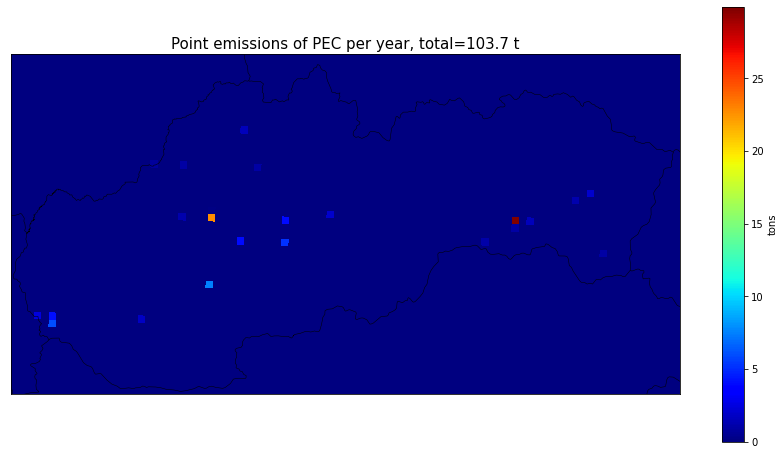

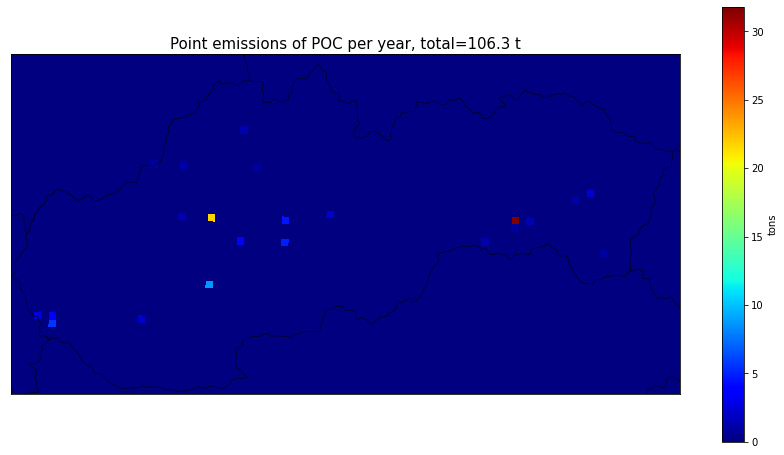

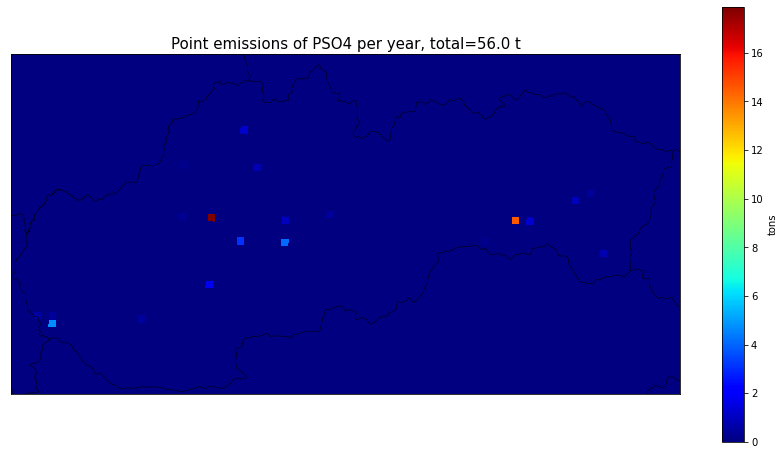

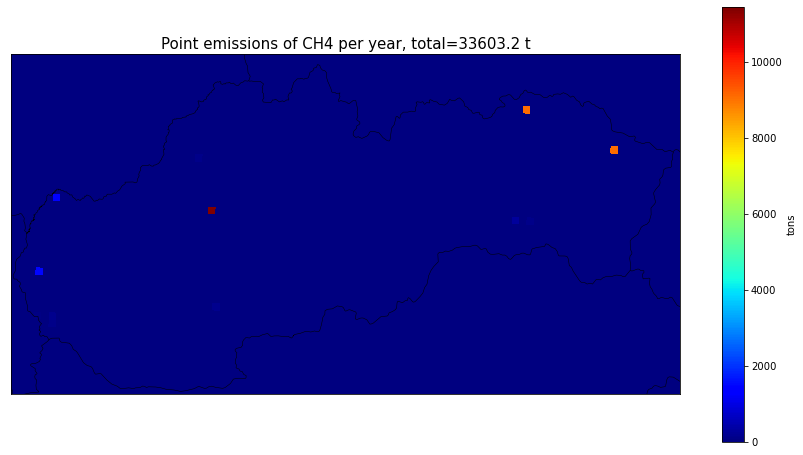

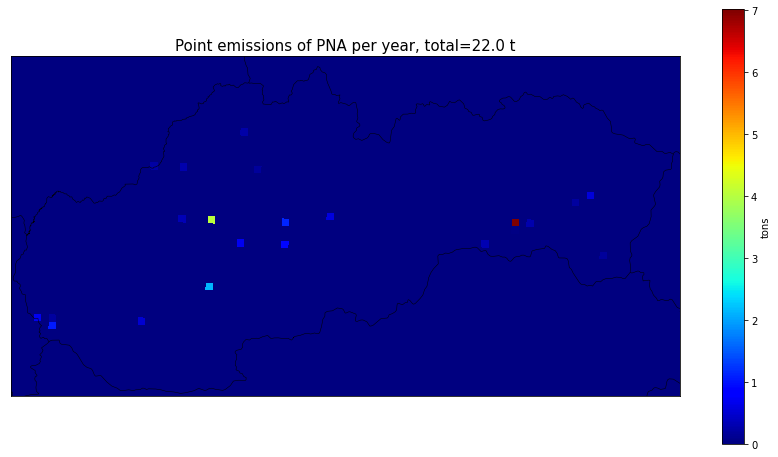

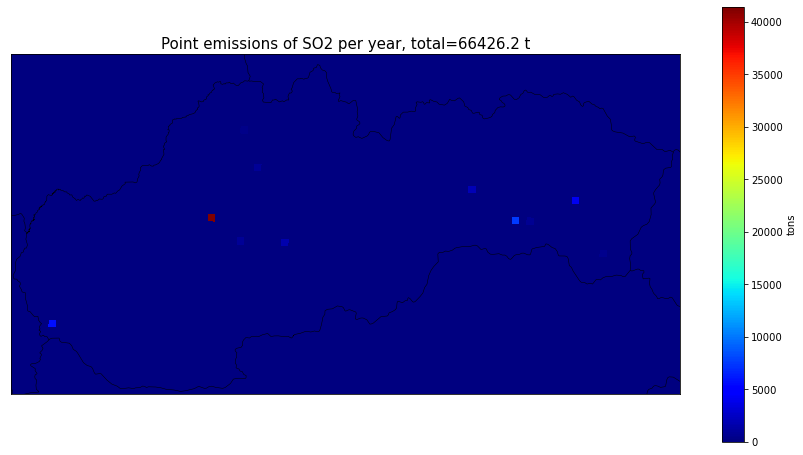

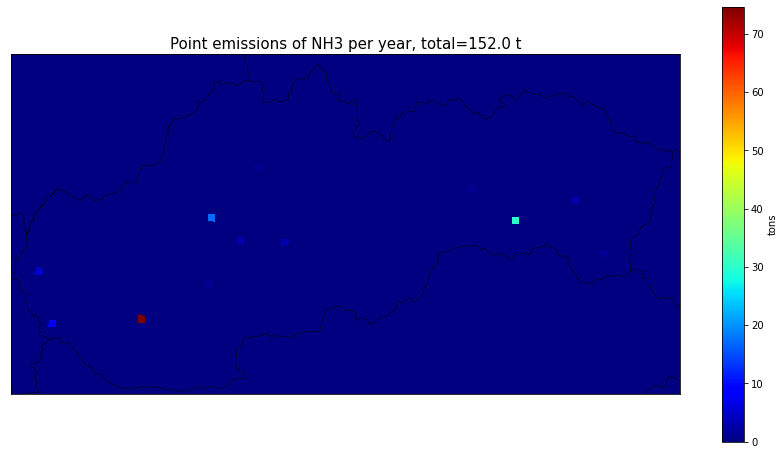

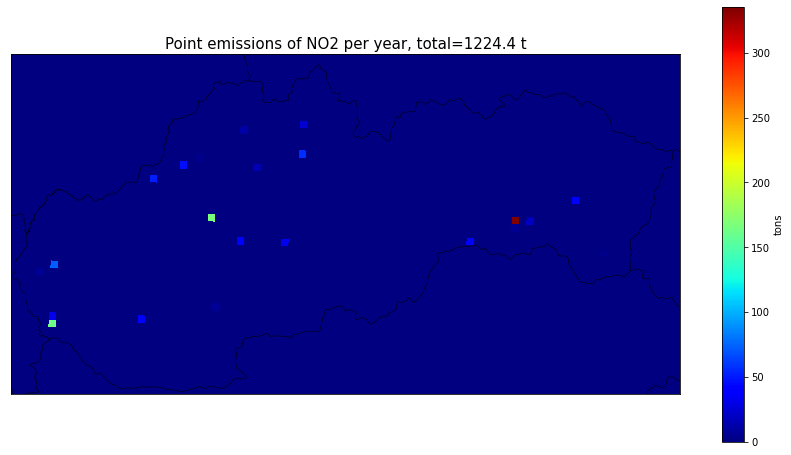

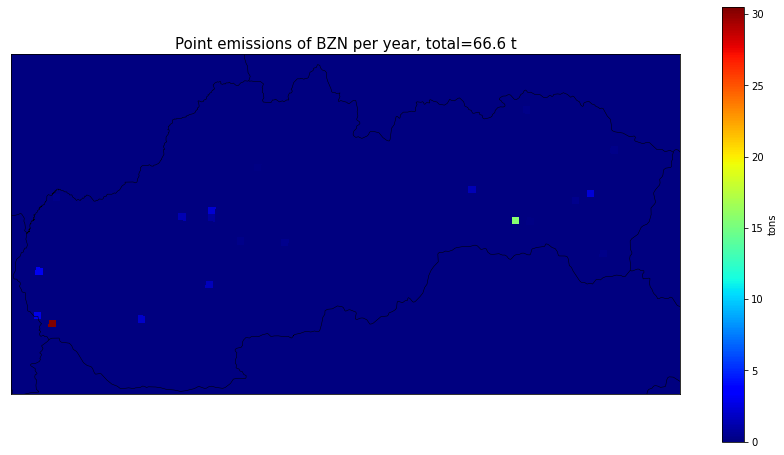

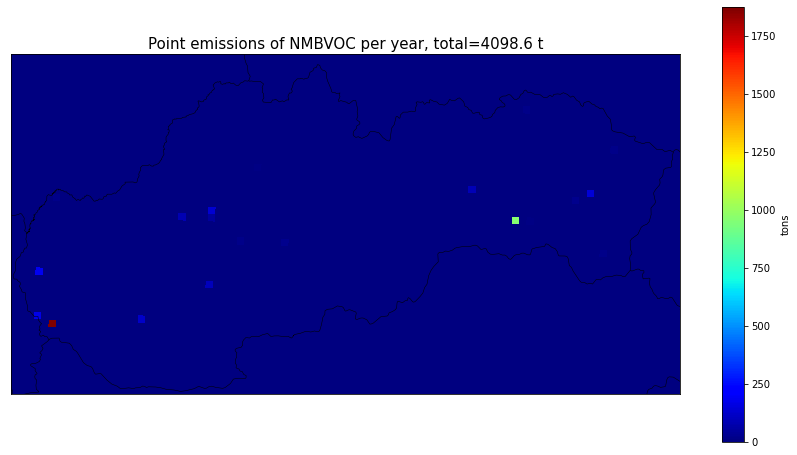

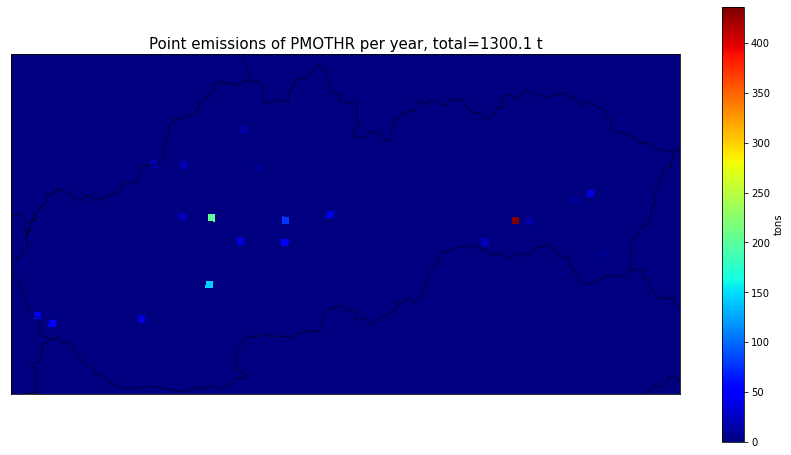

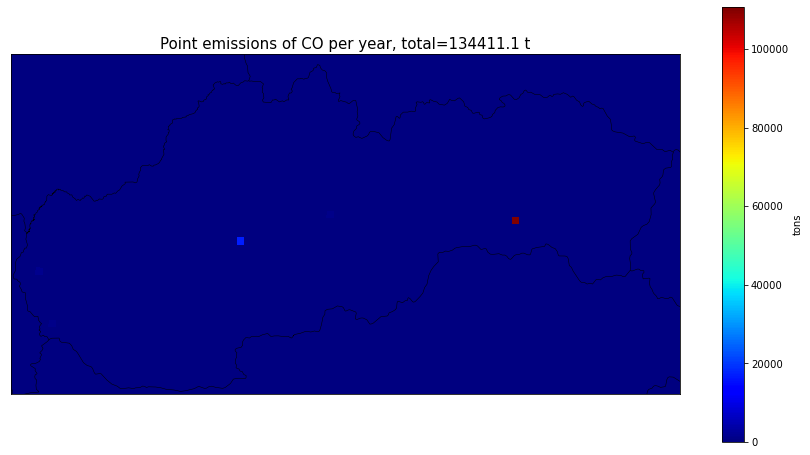

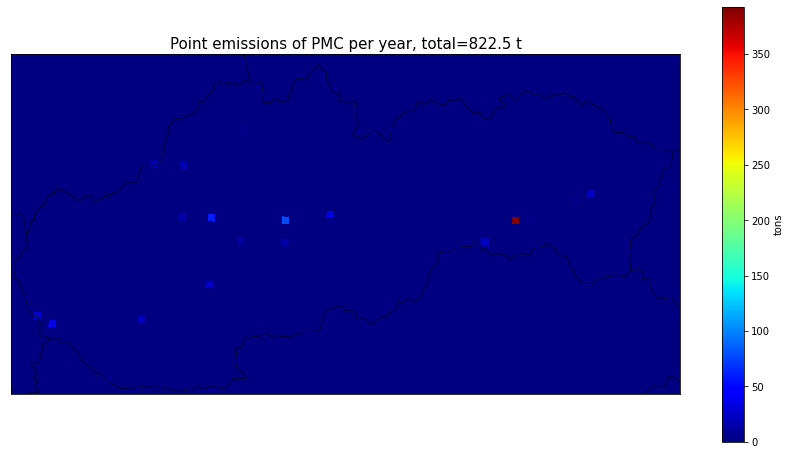

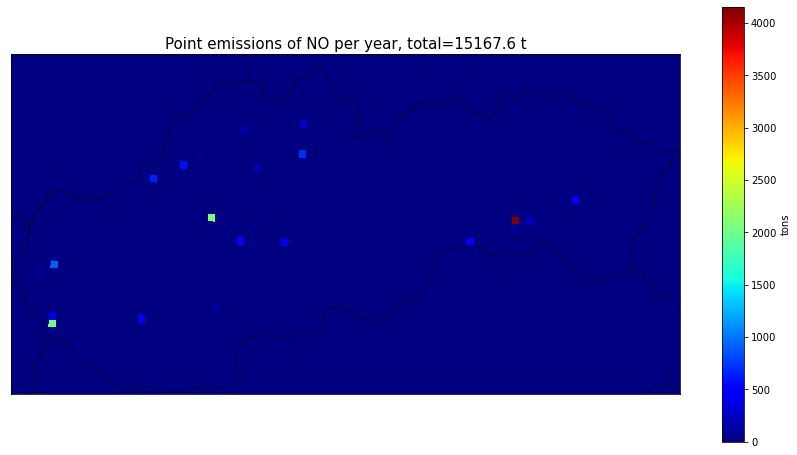

In [54]:
for pol in dic_pol_p:

    mapb.drawcountries()
    mapb.pcolormesh(lon,lat,dic_pol_p[pol],cmap=plt.cm.jet,latlon=True) 
    plt.colorbar(label='tons')
    plt.title(f'Point emissions of {pol} per year, total={np.sum(dic_pol_p[pol]):.1f} t', size=15)
    plt.show()

# Analyse for given pollutants